In [1]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer

In [2]:
st = SentenceTransformer("xlm-r-bert-base-nli-stsb-mean-tokens")
data = pd.read_csv("./comments.csv")

comments = data[['textOriginal', 'videoId']]

text = comments["textOriginal"].values.tolist()
labels = comments.index.to_list()

embs = st.encode(text)
pca = PCA(2).fit_transform(embs)

dico_font_video = {}

for i, videoid in enumerate(comments.videoId.unique()):
    dico_font_video[videoid] = i

font = [dico_font_video[videoid] for videoid in comments.videoId]

In [ ]:
kmeans = KMeans(5, n_init=80, max_iter=2000).fit(embs)

In [ ]:
center_indices = [
    int(np.argmin([np.sum((x-centroid)**2) for x in embs]))
    for centroid in kmeans.cluster_centers_]

commentaires_representants = [comments.textOriginal[i] for i in center_indices]
representants = ''
for i, comment in enumerate(commentaires_representants):
    representants += f'{i}:{comment} \n'
print(representants)

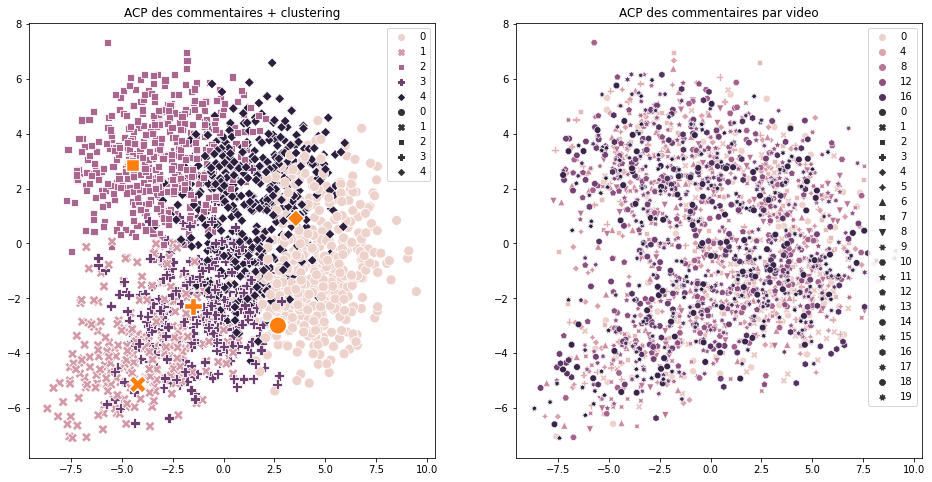

0:Merci pour ton travail de recherche et de vulgarisation ❤️ 
1:un régal, comme d'hab! Merci pour ce très beau travail 
2:J'adore! Une super vidéo encore une fois ! Merci pour ce que tu fais et la qualité de ton travail 
3:Le montage est toujours aussi bon c’est ouf 🤌🏼 
4:J'adore tes vidéos mecs, t'es un scientifique, moi j'y comprends rien ! Mais...les flamands rose existent !? Moi pas comprendre.
Au fait : tu me fais délirer avec tes montages ! J'ai adoré le ''Ta gueule !'' 



In [38]:
plt.subplots(figsize=(16, 8))
plt.subplot(121)
sns.scatterplot(x=pca[:, 0], y=pca[:, 1], hue=kmeans.labels_, style=kmeans.labels_, s=100)
sns.scatterplot(x = [pca[i, 0] for i in center_indices], 
                y=[pca[i, 1] for i in center_indices],
                style = [i for i in range(len(center_indices))], 
                s=300)
plt.title("ACP des commentaires + clustering")

plt.subplot(122)
sns.scatterplot(x=pca[:, 0], y=pca[:, 1], hue=font, style=font, s=50)
plt.title("ACP des commentaires par video")

plt.show()
print(representants)

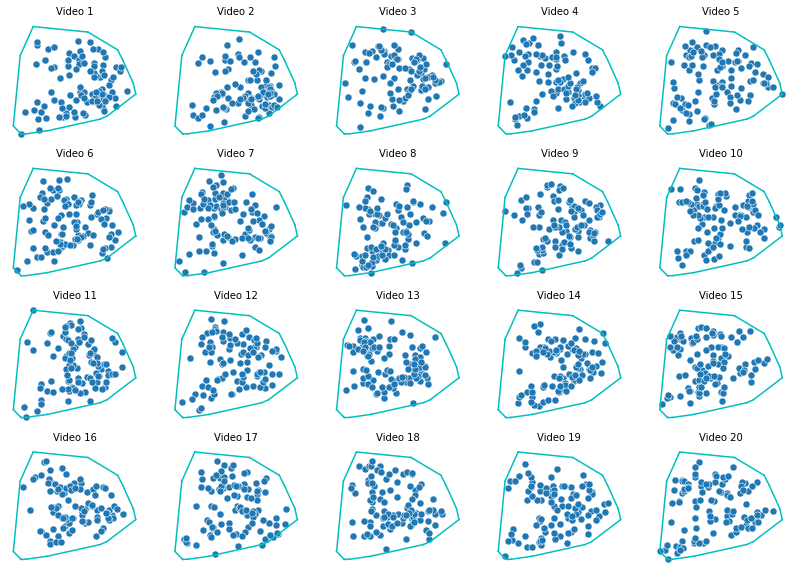

In [61]:
from scipy.spatial import ConvexHull

hull = ConvexHull(pca)

fig, axs = plt.subplots(4, 5, figsize=(14, 10))
for i, ax in enumerate(np.array(axs).flatten()):
    sns.scatterplot(x=[pca[j, 0] for j in range(len(font)) if font[j] == i],
                    y=[pca[j, 1] for j in range(len(font)) if font[j] == i],
                    s=50,
                    ax=ax)
    for simplex in hull.simplices:
            ax.plot(pca[simplex, 0], pca[simplex, 1], 'c')
    ax.set_title(f'Video {i+1}', fontsize=10)
    ax.axis('off')
plt.show()

In [ ]:
# S'intéresser aux valeurs de l'enveloppe convexe : quels sont les commentaires limites ?